In [ ]:
!pip install git+https://github.com/ElsevierSoftwareX/SOFTX_2018_114.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ElsevierSoftwareX/SOFTX_2018_114.git to /tmp/pip-req-build-3thuaa8s
  Running command git clone --filter=blob:none --quiet https://github.com/ElsevierSoftwareX/SOFTX_2018_114.git /tmp/pip-req-build-3thuaa8s
  Resolved https://github.com/ElsevierSoftwareX/SOFTX_2018_114.git to commit 2cf1ce42f50b1cf13d51786e68c1ae9cdccd1612
  Preparing metadata (setup.py) ... done


In [ ]:
from __future__ import division, absolute_import, print_function
import matplotlib.pyplot as plt
import numpy as np
from pyeit.mesh.wrapper import create

import pyeit.mesh as mesh
from pyeit.eit.fem import Forward
from pyeit.eit.utils import eit_scan_lines

import pyeit.eit.jac as jac
from pyeit.eit.interp2d import sim2pts
import time
import pandas as pd

# def circle(num_poly):
#     data = np.genfromtxt("Data/circle.csv", dtype=float, delimiter=',', names=True)
#     circle_point = []
#     for i in range(32):
#         circle_point.append([data['x'][i]/100,data['y'][i]/100])

#     pts = circle_point
#     pts = pts
#     n = [np.size(pts, 0)]
#     return pts, n
def circle(num_poly):
  """
  This function returns a list of points that form a circle.

  Args:
    num_poly: The number of points in the circle.

  Returns:
    A list of points that form a circle.
  """

  # Read data from CSV file.
  data = np.genfromtxt("./circle.csv", dtype=float, delimiter=',', names=True)

  # Create a list of points that are equally spaced around the circle.
  points = []
  for i in range(num_poly):
    angle = 2 * np.pi * i / num_poly
    x = np.cos(angle)
    y = np.sin(angle)
    points.append([x, y])

  # Return the list of points.
  return points


In [ ]:


start_time = time.time()

N_el = 8
# mesh_obj, el_pos = create(N_el, max_area=0.00005, curve=circle, refine=True)
mesh_obj, el_pos = create(32, h0=0.1)
pts = mesh_obj['node']
tri = mesh_obj['element']
x, y = pts[:, 0], pts[:, 1]

In [ ]:
def pyeit(inclusion,name):

#number_element = np.shape(tri)[0]
#for i in range(number_element):
#    cx = (x[mesh_obj['element'][i][0]]+x[mesh_obj['element'][i][1]]+x[mesh_obj['element'][i][2]])/3
#    cy = (y[mesh_obj['element'][i][0]]+y[mesh_obj['element'][i][1]]+y[mesh_obj['element'][i][2]])/3
#    point = Point(cx, cy)
#    if (polygon.contains(point)):
#        mesh_obj['perm'][i]=20

  perm = mesh_obj['perm']

  el_pos = []
  for elp in range (N_el):
      el_pos.append(4*elp)

  # el_pos = [ 0,4,8,12,16,20,24,28 ]
  # el_pos = [ 0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30 ]
  # el_pos = [ 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]


  el_pos = np.array(el_pos)
  fig, ax = plt.subplots(figsize=(5, 5))
  plt.triplot(pts[:, 0], pts[:, 1], tri)

  # fig, ax = plt.subplots(figsize=(5, 5))


  ax.tripcolor(x, y, tri, np.real(perm),
                edgecolors='k', shading='flat', alpha=0.5,
                cmap=plt.cm.Greys)

  for i, e in enumerate(el_pos):
      plt.plot(pts[el_pos[i], 0], pts[el_pos[i], 1], 'ro')
      plt.annotate(str(i+1), xy=(x[e], y[e]), color='k')

  #splt.axis([-0.5,0.5,-0.5,0.5])
  plt.grid()
  plt.show()


  """ 2. FEM simulation """
  el_dist, step = 1, 1
  ex_mat = eit_scan_lines(N_el, el_dist)


  """ 3. JAC solver """
  eit = jac.JAC(mesh_obj, el_pos, ex_mat=ex_mat, step=step,
                perm=1., parser='std', jac_normalized=False)

  """ 4. Initial setup """
  stomachRecord = []
  signalRecord = []
  measNum = []
  initialCount = 0
  Current = 1#mA
  frequency = 100000000#mA



  allDSN = []
  t = 1
  for m in range(t):

      directory = '/content/drive/MyDrive/TPB/bioimg-RDW/Data/'
      # bgfile = 'Background_Current=1mA_stomach_fasting_f=10000.0Hz'
      # objfile = 'Data_'+str(m+1)+'_Current=1mA_stomach_full_f=10000.0Hz'

     # bgfile = 'Homogen'
    #  objfile = 'Inclusion'

      data2 = pd.read_csv('/content/drive/MyDrive/TPB/bioimg-RDW/Data/Homogen .csv')
      data1 = pd.read_csv(inclusion)

      Z_Inclusion = np.array(data1['Z [Ohm]'])
      Z_mean = np.ones(40)
      Z_mean = Z_mean*np.mean(Z_Inclusion)
      Z_Homogen = np.array(data2['Z [Ohm]'])


      Zh = list(Z_Homogen)
      Zi = list(Z_Inclusion)

      vi = Z_Inclusion
      vh = Z_Homogen
      d_error = []
      c_error = []

      pVal=0.4
      lambVal=0.01
      eit.setup(p=pVal, lamb=lambVal, method='kotre')
      # ds = eit.solve_gs(vi, vh)
      ds = eit.solve(vi,vh,normalize=True)
      # ds = eit.jt_solve(vi, vh, normalize=False)
      ds[ds<0]=0
      ds[ds>10]=10

      # ds = eit.gn((vi-vh)/10, lamb_decay=0.01, lamb_min=1e-4, maxiter=1, verbose=True)
      ds_n = sim2pts(pts, tri, np.real(ds))

      print(np.shape(x),np.shape(y),np.shape(tri),np.shape(ds_n))

      allDSN.append(ds_n)


  m = 0
  for m in range(t):

      # plot EIT reconstruction
      fig, ax = plt.subplots(figsize=(5, 5))
      im = ax.tripcolor(x, y, tri, allDSN[m], shading='flat',cmap=plt.cm.jet)
      # for i, e in enumerate(el_pos):
      #     ax.annotate(str(i+1), xy=(x[e], y[e]), color='r')
      # fig.colorbar(im)
      ax.axis('off')
      # ax.set_aspect('equal')
      # fig.set_size_inches(6, 4)
      plt.savefig(directory+name+'.png', dpi=96)

      plt.show()
      print(np.mean(np.real(ds)))
      print("measTime=", time.time()-start_time)

      "plot empying by signal 16 1 2 3"
      # observed_signal = 1/(np.array(Zi[(13*15):13*16]+Zi[0:13*3]))
      observed_signal = 1/(vi)
      signalRecord.append(np.mean(observed_signal))
      measNum.append(m)

      if (m==0):
          initialSignal = sum(signalRecord)

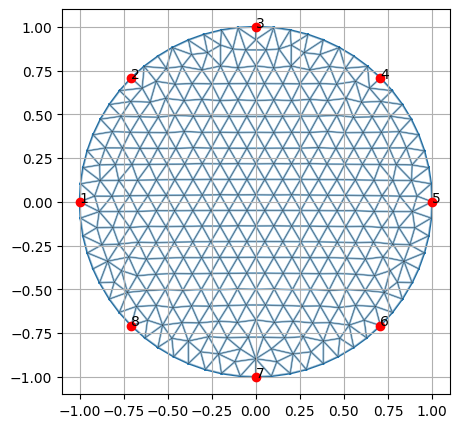

(373,) (373,) (680, 3) (373,)


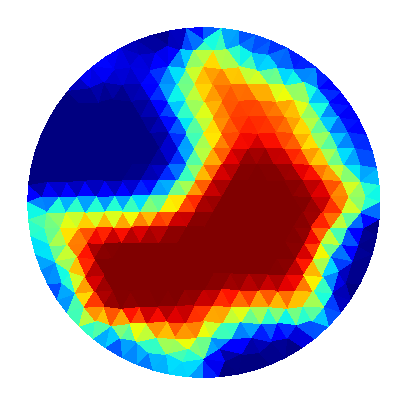

5.2387594656077905
measTime= 22.378085374832153


In [ ]:
## Health
health = '/content/drive/MyDrive/TPB/bioimg-RDW/Data/Health.csv'
name = 'health'
pyeit(health,name)

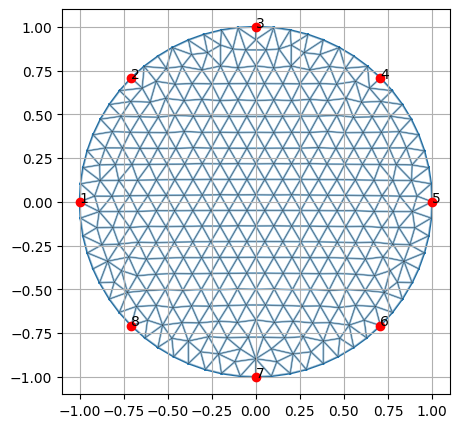

(373,) (373,) (680, 3) (373,)


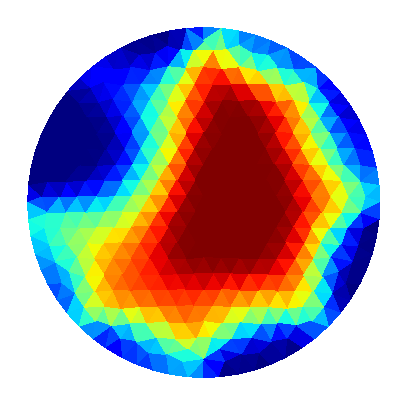

5.361906932481067
measTime= 28.55398464202881


In [ ]:
## Liposarcoma
liposarcoma = '/content/drive/MyDrive/TPB/bioimg-RDW/Data/Liposarcoma.csv'
name = 'liposarcoma'
pyeit(liposarcoma,name)

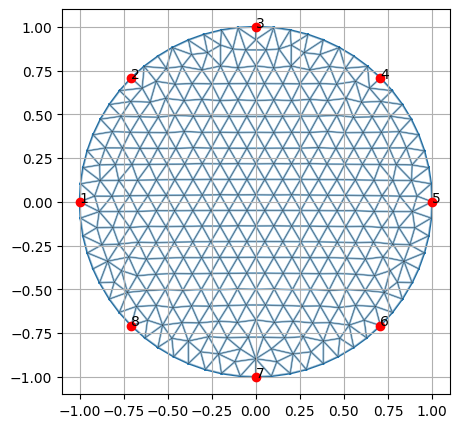

(373,) (373,) (680, 3) (373,)


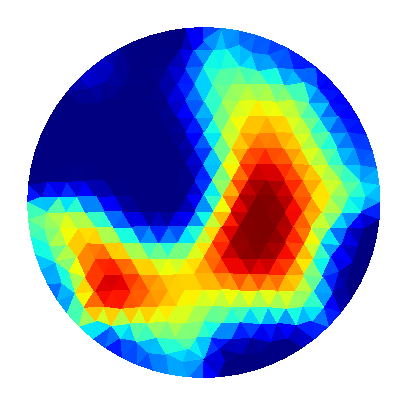

3.7363771424936503
measTime= 41.73557686805725


In [ ]:
## Symtomp
symptom = '/content/drive/MyDrive/TPB/bioimg-RDW/Data/Symptom.csv'
name = 'symptom'
pyeit(symptom,name)

Image matching Error between the two images (RMSE): 13.068550347222223


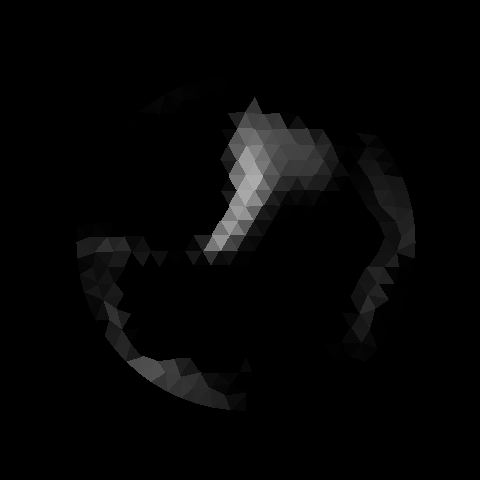

In [ ]:
# import required libraries MEAN SQUARE
import cv2
import numpy as np

health_img ='/content/drive/MyDrive/TPB/bioimg-RDW/Data/health.png'
liposarcoma_img = '/content/drive/MyDrive/TPB/bioimg-RDW/Data/liposarcoma.png'
symptom_img = '/content/drive/MyDrive/TPB/bioimg-RDW/Data/symptom.png'

# define the function to compute MSE between two images
def mse(img1, img2):
   h, w = img1.shape
   diff = cv2.subtract(img1, img2)
   err = np.sum(diff**2)
   mse = err/(float(h*w))
   return mse, diff

img1 = cv2.imread(health_img,0)
img2 = cv2.imread(liposarcoma_img,0)
from google.colab.patches import cv2_imshow

from google.colab.patches import cv2_imshow
error, diff = mse(img1, img2)
print("Image matching Error between the two images (RMSE):",error)

cv2_imshow(diff)

In [ ]:
# import the necessary packages
from skimage.metrics import structural_similarity as compare_ssim
import argparse
import imutils
import cv2
# construct the argument parse and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-f", "--first", required=True, help="first input image")
# ap.add_argument("-s", "--second", required=True, help="second")
# args = vars(ap.parse_args())

# load the two input images
imageA = cv2.imread(health_img)
imageB = cv2.imread(liposarcoma_img)
# convert the images to grayscale
grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)

# compute the Structural Similarity Index (SSIM) between the two
# images, ensuring that the difference image is returned
(score, diff) = compare_ssim(grayA, grayB, full=True)
diff = (diff * 255).astype("uint8")
print("SSIM: {}".format(score))

SSIM: 0.8662929162541647


In [ ]:
# threshold the difference image, followed by finding contours to
# obtain the regions of the two input images that differ
thresh = cv2.threshold(diff, 0, 255,
	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

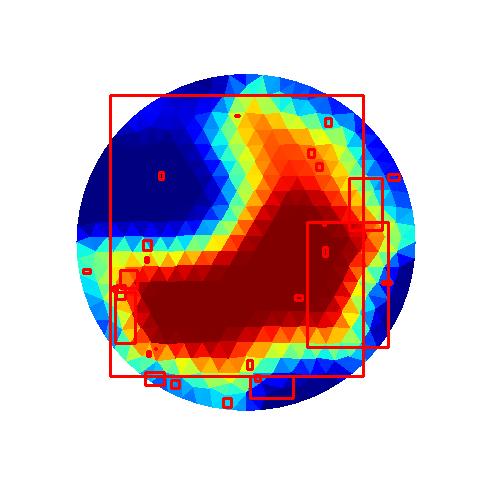

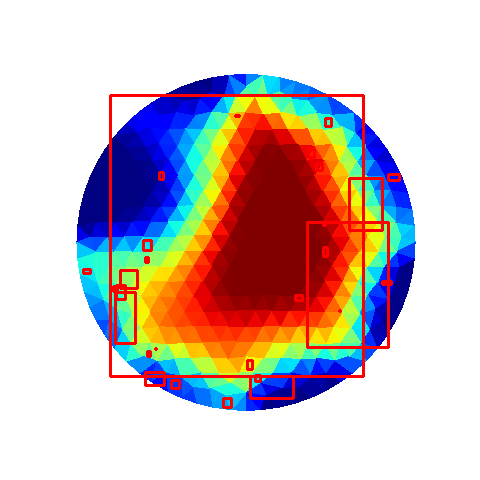

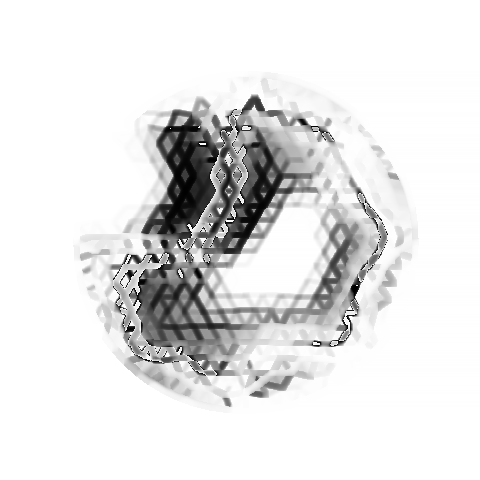

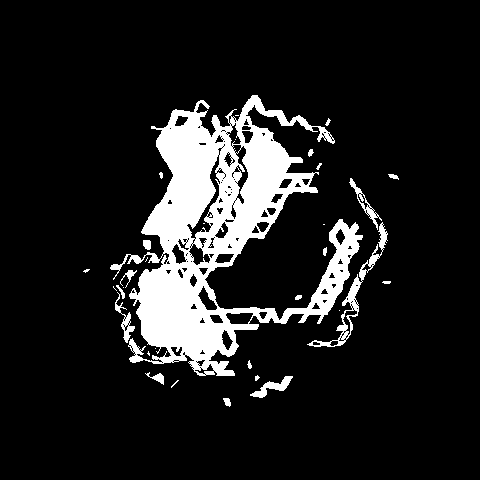

-1

In [ ]:
from google.colab.patches import cv2_imshow
# loop over the contours
for c in cnts:
	# compute the bounding box of the contour and then draw the
	# bounding box on both input images to represent where the two
	# images differ
	(x, y, w, h) = cv2.boundingRect(c)
	cv2.rectangle(imageA, (x, y), (x + w, y + h), (0, 0, 255), 2)
	cv2.rectangle(imageB, (x, y), (x + w, y + h), (0, 0, 255), 2)
# show the output images
cv2_imshow(imageA)
cv2_imshow(imageB)
cv2_imshow(diff)
cv2_imshow(thresh)
cv2.waitKey(0)